<a href="https://colab.research.google.com/github/aldodec/Covid19-Mex/blob/master/Covid19_MX_SIR_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score
import scipy.integrate
import scipy.optimize
import pandas as pd
import datetime


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
date = ['2020-02-28','2020-02-29','2020-03-01','2020-03-02','2020-03-03','2020-03-04'
       ,'2020-03-05','2020-03-06','2020-03-07','2020-03-08','2020-03-09','2020-03-10',
       '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16',
       '2020-03-17','2020-03-18','2020-03-19','2020-03-20','2020-03-21','2020-03-22',
        '2020-03-23','2020-03-24','2020-03-25','2020-03-26','2020-03-27','2020-03-28',
        '2020-03-29','2020-03-30','2020-03-31','2020-04-01','2020-04-02','2020-04-03',
        '2020-04-04','2020-04-05','2020-04-06','2020-04-07','2020-04-08','2020-04-09',
        '2020-04-10','2020-04-11','2020-04-12','2020-04-13','2020-04-14','2020-04-15',
        '2020-04-16','2020-04-17','2020-04-18','2020-04-19','2020-04-20','2020-04-21',
        '2020-04-22','2020-04-23','2020-04-24','2020-04-25','2020-04-26','2020-04-27',
        '2020-04-28','2020-04-29','2020-04-30','2020-05-01','2020-05-02','2020-05-03',
        '2020-05-04','2020-05-05','2020-05-06','2020-05-07']
# ,'2020-05-06'
positives = [3,4,5,5,5,5,5,6,7,7,7,7,11,14,26,41,53,82,93,118,164,203,251,316
                   ,367,405,475,585,717,848,993,1094,1215,1378,1510,1688,1890,2143,
                   2439,2785,3181,3441,3844,4219,4661,5014,5399,5847,6297,6875,7497,
                   8261,8772,9501,10544,11633,12872,13842,14677,15529,16752,17799,
             19224,20739,22088,23471,24905,26025,27634,29616]

days = [i for i in range(len(positives))]

Logistic Fit


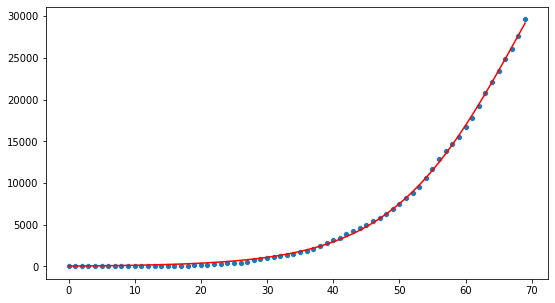

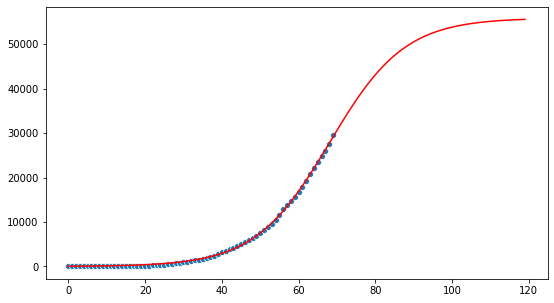

R^2:  0.9994775292380764
A:  1083.1999290849203
K:  55857.33527271451
r:  0.10255066069633746
SIR Fit
beta: 0.3660260540314395
gamma: 0.26437010890371004
R0: 1.3845213271245995
N0: 125573.5120710053
R^2 Score: 0.9995518655990395


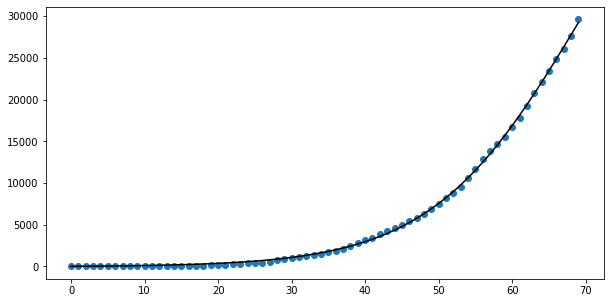

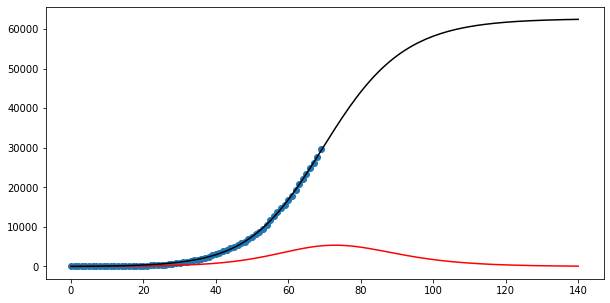

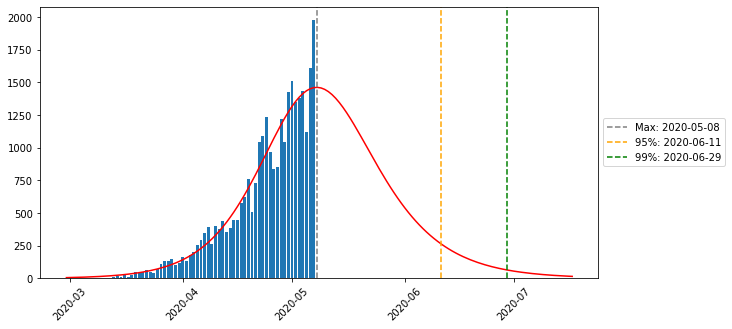

Date of max no. of new positives: 2020-05-08 00:00:00
Total positives: 62447.54985354276


In [3]:
def logistic(t,A,K,r):  #  guessing
  return K/(1+A*np.exp(-r*t))

g = [1000,60000,1/10] # make a guess
t = days
pc = positives

c, cov = curve_fit(logistic,t,pc,g)

n = len(positives)

t = days
y = np.empty(n)

y_future = np.empty(n+50)
t_future = np.empty(n+50)

for i in range(n):
    y[i] = logistic(t[i],c[0],c[1],c[2])

for i in range(n+50):
    y_future[i] = logistic(i,c[0],c[1],c[2])
    t_future[i] = i

print('Logistic Fit')

plt.figure(figsize=(9,5))
sns.scatterplot(x = days, y = positives)
sns.lineplot(t, y,color = 'red')
plt.show()

plt.figure(figsize=(9,5))
sns.scatterplot(x = days, y = positives)
sns.lineplot(x = t_future, y= y_future,color = 'red')
plt.show()

print('R^2: ',r2_score(positives,y))
print('A: ',c[0])
print('K: ',c[1])
print('r: ',c[2])

K0 = c[1]
r0 = c[2]
A0 = c[0]
C0 = K0/(A0+1)

print(20*'====')



def SIR_model(y0,t,beta,gamma,N):

  S, I, R = y0

  dS_dt = -beta*S*I/N
  dI_dt = beta*S*I/N - gamma*I
  dR_dt = gamma*I

  return([dS_dt,dI_dt,dR_dt])

def loss_function(params):
  
  beta = params[0]
  I0 = params[1]
  gamma = params[2]
  N0 = params[3]
  S0 = N0 - I0
  R0 = 0
  t = np.linspace(0,len(positives)-1,len(positives))  

  solution = scipy.integrate.odeint(SIR_model,y0=[S0,I0,R0],t=t,args=(beta,gamma,N0))
  solution = np.array(solution)
  y_pred = solution[:,2]+solution[:,1]
  loss = np.sum(((y_pred) - (positives))**2)

  return loss

guess = np.array([3*r0,C0,2*r0,2*K0])
params_fit = scipy.optimize.fmin(func=loss_function, x0=guess)
beta_fit = params_fit[0]
I0_fit = params_fit[1]
gamma_fit = params_fit[2]
N0_fit = params_fit[3] 
S0 = N0_fit - I0_fit
R0 = 0

print(20*'====')

print('SIR Fit')

print(20*'====')

print('beta:',beta_fit)
print('gamma:',gamma_fit)
print('R0:',beta_fit/gamma_fit)
print('N0:',N0_fit)

t = np.linspace(0,len(positives)-1,len(positives))
solution = scipy.integrate.odeint(SIR_model,y0=[S0,I0_fit,R0],t=t,args=(beta_fit,gamma_fit,N0_fit))
solution = np.array(solution)  
r2 = r2_score(solution[:,2]+solution[:,1],positives) 
print('R^2 Score:',r2)


plt.figure(figsize=(10,5))
plt.plot(t,solution[:,2]+solution[:,1],color = 'black')
plt.scatter(days,positives)
plt.show()

T = np.linspace(0,140,140+1)
solution_future = scipy.integrate.odeint(SIR_model,y0=[S0,I0_fit,R0],t=T,args=(beta_fit,gamma_fit,N0_fit))
solution_future = np.array(solution_future)

df = pd.DataFrame({'days':days,'positives':positives,'date':date})
df['daily_positives'] = df['positives'] - df['positives'].shift(1)
df['date'] = pd.to_datetime(df['date'])

start_date = pd.to_datetime(date[0])

df_pred = pd.DataFrame()
df_pred['time'] = T
df_pred['positive_pred'] =( solution_future[:,2]+solution_future[:,1])
df_pred['daily_pos_pred'] = df_pred['positive_pred'] - df_pred['positive_pred'].shift(1)
df_pred['date'] = [start_date + datetime.timedelta(days=i) for i in T]

plt.figure(figsize=(10,5))
plt.plot(T,solution_future[:,1],color= 'red')
plt.plot(T,solution_future[:,2]+solution_future[:,1],color = 'black')
plt.scatter(days,np.array(positives))
plt.show()

max_day = df_pred[df_pred['daily_pos_pred']==df_pred['daily_pos_pred'].max()]['time'].iloc[0]
max_date = start_date + datetime.timedelta(days=max_day)
total = df_pred['positive_pred'].iloc[-1:].iloc[0]
df_pred['CDF'] = df_pred['positive_pred']/total

alpha_95 = 0.95
alpha_99 = 0.99

date_95 = df_pred.iloc[(df_pred['CDF']-alpha_95).abs().argsort()[:1]]['date'].iloc[0]
date_99 = df_pred.iloc[(df_pred['CDF']-alpha_99).abs().argsort()[:1]]['date'].iloc[0]

plt.figure(figsize=(10,5))
plt.plot(df_pred['date'],df_pred['daily_pos_pred'],color= 'r' )
plt.axvline(max_date,ls = '--',color = 'grey',label = 'Max: {}'.format(max_date.strftime('%Y-%m-%d')))
plt.axvline(date_95,ls = '--',color = 'orange',label = '95%: {}'.format(date_95.strftime('%Y-%m-%d')))
plt.axvline(date_99,ls = '--',color = 'green',label = '99%: {}'.format(date_99.strftime('%Y-%m-%d')))
plt.bar(df['date'],df['daily_positives'])
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

total_infected = solution_future[-1:,2]+solution_future[-1:,1]
print(20*'====')
print('Date of max no. of new positives:',max_date)
print('Total positives:',total_infected[0])